In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gym

%matplotlib inline

In [2]:
with open('./train_test_data/humanoid_train_test-small.pkl', 'rb') as inf:
    X_tv, y_tv, X_test, y_test = pickle.load(inf)
print(X_tv.shape, X_test.shape, y_tv.shape, y_test.shape)

(16008, 376) (4002, 376) (16008, 17) (4002, 17)


In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Build a network

* observation is an 11-dim array
* action is a (1, 3) shaped array

In [4]:
# None: batch size could vary
x_plh = tf.placeholder(tf.float32, shape=[None, X_tv.shape[1]])
y_plh = tf.placeholder(tf.float32, shape=[None, y_tv.shape[1]])

In [5]:
hidden_lay_size = 15
Wh_var = weight_variable([x_plh.shape.dims[1].value, hidden_lay_size])
bh_var = bias_variable([hidden_lay_size])
# hh = tf.nn.relu(tf.matmul(x_plh, Wh_var) + bh_var)
hh = tf.nn.sigmoid(tf.matmul(x_plh, Wh_var) + bh_var)

In [6]:
W_var = weight_variable([hidden_lay_size, y_plh.shape.dims[1].value])
b_var = bias_variable([y_plh.shape.dims[1].value])

In [7]:
y_pred = tf.matmul(hh, W_var) + b_var

In [8]:
with tf.name_scope('mse'):
    mse = tf.losses.mean_squared_error(labels=y_plh, predictions=y_pred)
    mse = tf.cast(mse, tf.float32)

In [9]:
with tf.name_scope('adam_optimizer'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(mse)

0,1,2,3,4,5,6,7,8,9,
0.623086 0.622847


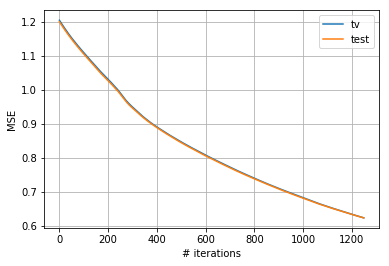

In [10]:
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

mse_tv, mse_test = [], []

bs = 128      # batch size
for k in range(10): # num. epochs
    print(k, end=',')
    for i in range(X_tv.shape[0] // bs):
        _x = X_tv[i * bs : (i+1) * bs, :]
        _y = y_tv[i * bs : (i+1) * bs, :]
        train_op.run(feed_dict={x_plh: _x, y_plh: _y})

        # this step of calculation is slow and won't scale
        mse_tv.append(mse.eval(feed_dict={x_plh: X_tv, y_plh: y_tv}))
        mse_test.append(mse.eval(feed_dict={x_plh: X_test, y_plh: y_test}))

plt.plot(mse_tv, label='tv')
plt.plot(mse_test, label='test')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.grid()

print()
print(mse_tv[-1], mse_test[-1])

In [11]:
len(mse_test)

1250

# Visualize performance

In [12]:
# saver = tf.train.Saver()

# sess = tf.InteractiveSession()
# saver.restore(sess, "/tmp/model/model.ckpt")

In [14]:
def pred_action(obs):
    return y_pred.eval(feed_dict={x_plh: obs.reshape(1, -1)})

env = gym.make('Humanoid-v1')

totalr_list = []
max_timesteps = 600
for _ in range(3):
    print(_, end=',')
    totalr = 0
    obs = env.reset()
    for k in range(max_timesteps):
        action = pred_action(obs[None,:])
        obs, r, done, _ = env.step(action)
        totalr += r
#         env.render()
#     env.render(close=True)
    totalr_list.append(totalr)
print()
print(totalr_list)
print(np.mean(totalr_list))
print(np.std(totalr_list))

0,1,2,
[2901.1512998677845, 2911.7216344824765, 2900.6944941324896]
2904.52247616
5.09398850111
